In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt','r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in  enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [31]:
#build dataset
block_size = 8

def build_dataset(words):
    X,y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)    
    return X,y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_tr,y_tr = build_dataset(words[:n1])
X_dev,y_dev = build_dataset(words[n1:n2])    
X_te , y_te = build_dataset(words[n2:])

In [32]:
X_tr[1]

tensor([ 0,  0,  0,  0,  0,  0,  0, 25])

In [33]:
for x,y in zip(X_tr[:5],y_tr[:5]):
    print(''.join(itos[ix.item()] for ix in x),'---->',itos[y.item()])

........ ----> y
.......y ----> u
......yu ----> h
.....yuh ----> e
....yuhe ----> n


In [53]:
class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn(fan_in,fan_out) /fan_in **0.5 #initalizing weight
        self.bias = torch.randn(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else[self.bias])
    
class BatchNorm:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        """
        if True mean and variance are computed from the current batch.
        Instead of using batch statistics, it uses the running mean and variance
        collected during training.
        """
        self.Training = True 
    #backward
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    # training with running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self,x):
        if self.Training:
            if x.ndim == 2:
                dim= 0
            if x.ndim ==3:
                dim = (0,1)
            x_mean = x.mean(dim,keepdim=True)
            x_var = x.var(dim,keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        #Normalize
        xhat = (x-x_mean)/torch.sqrt(x_var + self.eps)
        self.out =  self.gamma * xhat + self.beta
        #update buffer
        if self.Training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return[self.gamma,self.beta]
                

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
            

class Embedding:
    def __init__(self,num_embedding,embedding_dim):
        self.weight = torch.randn((num_embedding,embedding_dim))
        self.out = None
        
    def __call__(self,x):
        self.out = self.weight[x]
        
        return self.out
    
    def parameters(self):
        return[self.weight]
    
class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
        
    def __call__(self,x):
        B,T,C = x.shape
        x = x.view(B, T//self.n ,C*self.n)
        
        if x.shape[1]==1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers = layers
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [54]:
torch.manual_seed(42)

In [58]:
n_emb = 10  # the dim of chas embedding vectors
n_hidden = 200 # num of neurons in hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size,n_emb),
    FlattenConsecutive(2),Linear(n_emb*2,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total Parameters
for p in parameters:
    p.requires_grad = True

170897


In [56]:
for layer in model.layers:
    print(layer.__class__.__name__,":",tuple(layer.out.shape)) 

AttributeError: 'Embedding' object has no attribute 'out'

In [60]:
epochs = 200000
batch_size = 64
lossi = []

for i in range(epochs):
    #create mini batch
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    Xb,yb = X_tr[ix],y_tr[ix] #batch 
    #forwad pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,yb)
    
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<15000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 ==0 :
        print(f"{i:7d}/{epochs:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())
    
   

      0/ 200000:3.601258
   1000/ 200000:2.445781
   2000/ 200000:2.163294
   3000/ 200000:2.156123
   4000/ 200000:1.877807
   5000/ 200000:1.928720
   6000/ 200000:2.108773
   7000/ 200000:2.014763
   8000/ 200000:2.096709
   9000/ 200000:2.098012
  10000/ 200000:2.259810
  11000/ 200000:2.151398
  12000/ 200000:1.855546
  13000/ 200000:2.088605
  14000/ 200000:1.856511
  15000/ 200000:1.918713
  16000/ 200000:1.997524
  17000/ 200000:1.878388
  18000/ 200000:2.029017
  19000/ 200000:1.859951
  20000/ 200000:1.779461
  21000/ 200000:1.912313
  22000/ 200000:1.743225
  23000/ 200000:1.783720
  24000/ 200000:1.956180
  25000/ 200000:1.658418
  26000/ 200000:1.724108
  27000/ 200000:2.051022
  28000/ 200000:1.678259
  29000/ 200000:1.957638
  30000/ 200000:2.039892
  31000/ 200000:1.935194
  32000/ 200000:1.795542
  33000/ 200000:2.028881
  34000/ 200000:1.873674
  35000/ 200000:1.818164
  36000/ 200000:1.788941
  37000/ 200000:2.197293
  38000/ 200000:1.707113
  39000/ 200000:1.686658


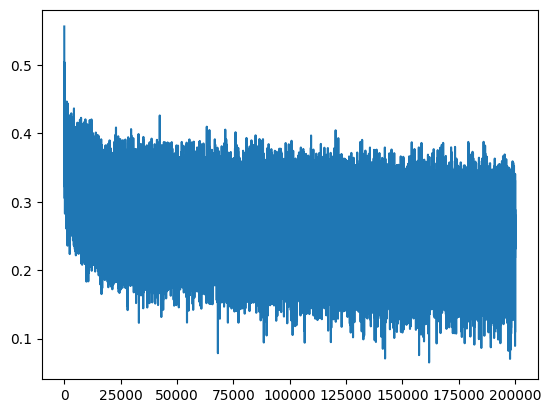

In [61]:
plt.plot(lossi)

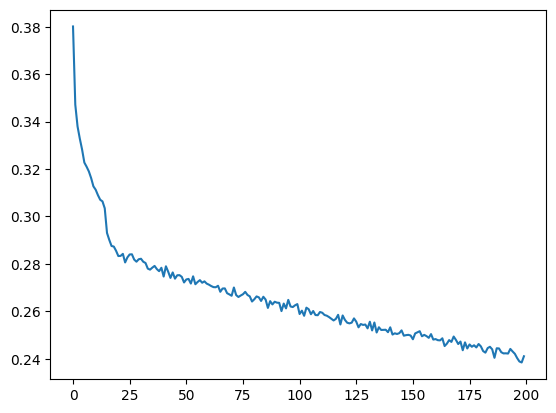

In [62]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [63]:
torch.tensor(lossi).view(-1,1000).mean(1).shape

torch.Size([200])

In [64]:
# put layers into eval mode
for layer in model.layers:
    layer.Training = False

In [65]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(X_tr,y_tr),
        'val':(X_dev,y_dev),
        'test':(X_te,y_te),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item()) 
    
split_loss('train')       
split_loss('val')       

train 1.7205545902252197
val 2.0135815143585205


In [66]:
#sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim = 1)
        #sample from the distribution
        ix = torch.multinomial(probs,num_samples=1).item()
        #shift the conetxt window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

anjelie.
asees.
apolon.
raine.
arieton.
kasham.
tailee.
sherlynn.
royal.
tajmane.
kaisen.
azel.
olevan.
emyah.
asrim.
dakai.
horgi.
srielyn.
harra.
cheylandaz.
